## Skin Cancer Binary Classification CNN HOTARU v1.21

The following notebook displays how the fourth version of the CNN model for skin cancer identification HOTARU was made.

The aim of this CNN model is to determine whether a photo provided by an enduser displays signs of skin cancer. It does not aim to identify what kind of skin cancer it is, but rather determines the presence of skin cancer.

This model is one half of the identification program. HOTARU v1.21 is accompanied by SPARK v1.1.

This model consists of a CNN section encapsulated into a Sequential object, which ends with an output layer that displays a value between 0 and 1. The closer it is to 0, the more convinced the model is that the photo does not show skin cancer, and vice versa (1 being indicating skin cancer).

**Changes done**
- Further attempts to improve F1-score.

In [1]:
# Importing relevant packages
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Resizing, RandomContrast
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import skimage
from skimage import io, color, exposure
from skimage.filters import threshold_otsu

C:\Users\dalet\AppData\Local\Temp\ipykernel_11540\3595835252.py:12: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
# Avoiding OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

In [3]:
# Defining datasets, which are already preprocessed prior to feeding to model
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed_n/train', image_size=(300,300), batch_size=32)
val_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed_n/val', image_size=(300,300), batch_size=32)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory('processed_n/test', image_size=(300,300), batch_size=32)

Found 6994 files belonging to 2 classes.
Found 874 files belonging to 2 classes.
Found 876 files belonging to 2 classes.


# Creating the CNN part of the model

In [4]:
# Creating Sequential object
cnn = Sequential()

In [5]:
# Adding layers to Sequential object
cnn.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(300,300,3))) # Input layer of CNN
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu'))
cnn.add(Dropout(0.25))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid')) # Output layer of CNN, only producing a value between 0 and 1

In [6]:
# Compiling the CNN
cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

In [7]:
# Summary of the CNN
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 150, 150, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 37, 37, 64)        0

# Logging

In [8]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Training

In [10]:
hist = cnn.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[tensorboard_callback])

Epoch 1/100
219/219 [==============================] - 92s 421ms/step - loss: 0.3073 - accuracy: 0.8732 - precision: 0.8962 - recall: 0.9010 - val_loss: 0.2403 - val_accuracy: 0.9039 - val_precision: 0.8995 - val_recall: 0.9523
Epoch 2/100
219/219 [==============================] - 88s 403ms/step - loss: 0.1963 - accuracy: 0.9206 - precision: 0.9391 - recall: 0.9333 - val_loss: 0.2176 - val_accuracy: 0.9188 - val_precision: 0.9309 - val_recall: 0.9394
Epoch 3/100
219/219 [==============================] - 87s 399ms/step - loss: 0.1273 - accuracy: 0.9491 - precision: 0.9643 - recall: 0.9537 - val_loss: 0.2310 - val_accuracy: 0.9142 - val_precision: 0.9352 - val_recall: 0.9266
Epoch 4/100
219/219 [==============================] - 87s 396ms/step - loss: 0.0693 - accuracy: 0.9737 - precision: 0.9796 - recall: 0.9782 - val_loss: 0.3346 - val_accuracy: 0.9108 - val_precision: 0.9177 - val_recall: 0.9413
Epoch 5/100
219/219 [==============================] - 86s 394ms/step - loss: 0.0603 - a

# Evaluation - Loss, Accuracy, Precision, Recall and F1-Score

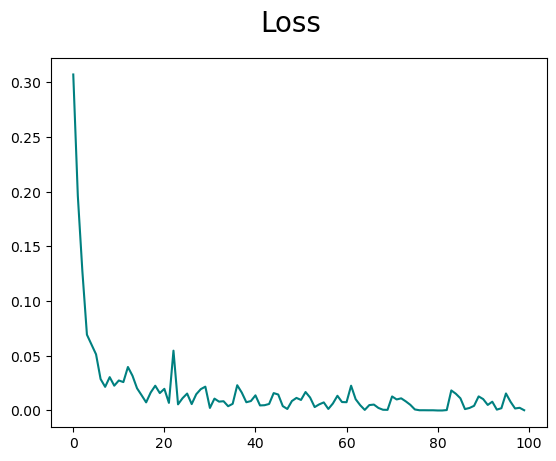

In [11]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
fig.suptitle('Loss', fontsize=20)
plt.show()

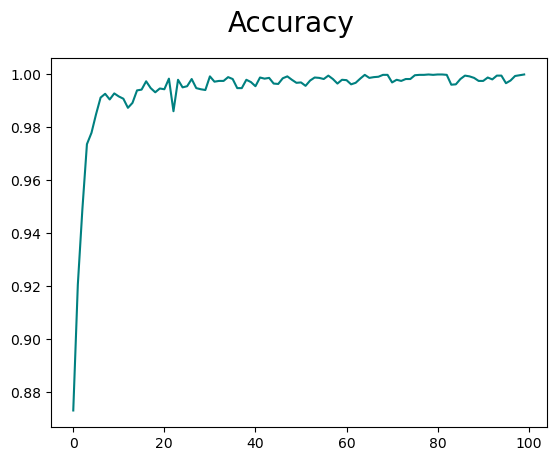

In [12]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.show()

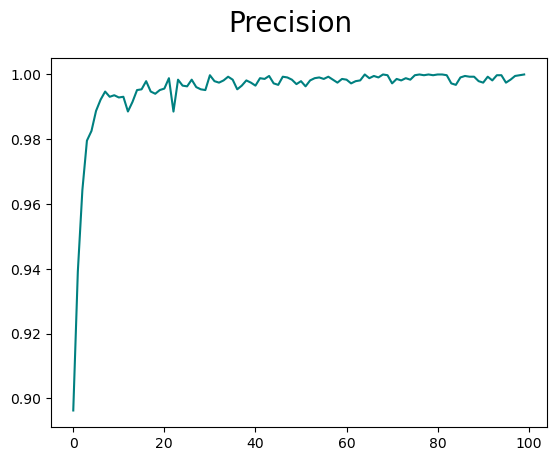

In [13]:
fig = plt.figure()
plt.plot(hist.history['precision'], color='teal', label='precision')
fig.suptitle('Precision', fontsize=20)
plt.show()

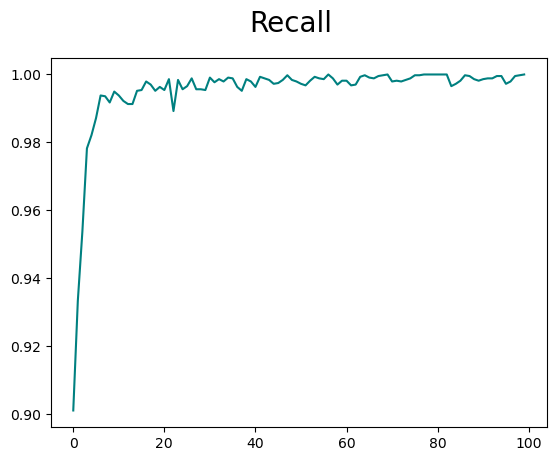

In [14]:
fig = plt.figure()
plt.plot(hist.history['recall'], color='teal', label='recall')
fig.suptitle('Recall', fontsize=20)
plt.show()

In [15]:
# Calculating F1-score for every epoch

f1_score = []

for i in range(len(hist.history['precision'])):
    x = 2 * ((hist.history['precision'][i] * hist.history['recall'][i]) / (hist.history['precision'][i] + hist.history['recall'][i]))
    f1_score.append(x)

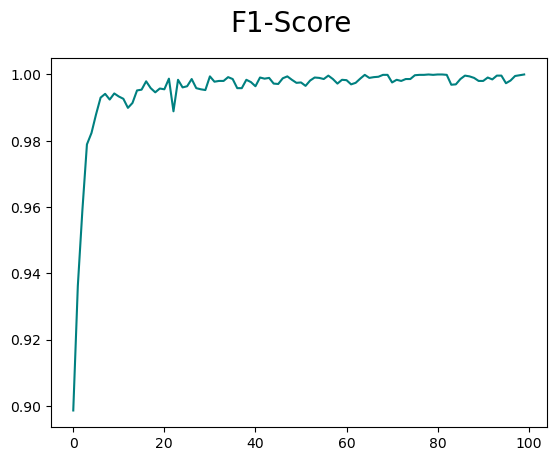

In [16]:
fig = plt.figure()
plt.plot(f1_score, color='teal', label='f1-score')
fig.suptitle('F1-Score', fontsize=20)
plt.show()

# Testing with a batch

In [17]:
# Evaluating the model using the prediction dataset
model_loss, model_accuracy, model_precision, model_recall = cnn.evaluate(test_dataset,verbose=1)

# Calculating F1-score manually
f1score = 2 * ((model_precision * model_recall) / (model_precision + model_recall))

# Printing metrics
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}, F1-score: {f1score}")

28/28 [==============================] - 3s 104ms/step - loss: 1.3058 - accuracy: 0.9075 - precision: 0.9189 - recall: 0.9341
Loss: 1.3057655096054077, Accuracy: 0.9075342416763306, Precision: 0.9189189076423645, Recall: 0.9340659379959106, F1-score: 0.9264305139133332


In [18]:
# Creating confusion matrix and classification report

# Creating ground truth label list
classes = test_dataset.class_names 
y_true = []

for images, label in test_dataset:   
    for e in label:
        y_true.append(int(classes[e]))

# Creating prediction list
y_pred = cnn.predict(test_dataset)
y_pred = np.round(y_pred).tolist()

# Converting all lists gathered to arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Generating confusion matrix
cm = confusion_matrix(y_true, y_pred)        

print(" ")
print("Confusion matrix:") 
print("---------------------")
print(cm)
print(" ")

# Generating classification report
clr = classification_report(y_true, y_pred, target_names=classes)

print("Classification Report:") 
print("---------------------")
print(clr)

28/28 [==============================] - 3s 92ms/step
 
Confusion matrix:
---------------------
[[128 202]
 [193 353]]
 
Classification Report:
---------------------
              precision    recall  f1-score   support

           0       0.40      0.39      0.39       330
           1       0.64      0.65      0.64       546

    accuracy                           0.55       876
   macro avg       0.52      0.52      0.52       876
weighted avg       0.55      0.55      0.55       876



**Result**

Accuracy of 55-90%, precision of 91%, recall of 93% and F1-score of 92.6%.

The difference in performance when comparing HOTARU v1.21 to v1.2 is very much like night and day. While v1.21 brought out more true negatives than v1.2, it is at the expense of having more false negatives and positives. In addition, the performance of v1.21 is significantly lower when compared with v1.2. It is therefore determined that reducing the dataset in order to reach a less disparate proportion of data is detrimental for the model's performance.

# Testing with a single picture / Showcasing SPARK script

In [19]:
# Creating preprocessing function
def prepro(img_path, cmap_type='gray'):
    # Loading in image
    img = Image.open(img_path)
    
    '''
    Section 1: Translating image into array
    '''
    # Resize the image to a consistent size (e.g., 224x224)
    img = img.resize((300, 300))

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # Create original image variable for comparison - this is not in image_preprocessing.py
    img_ori = img_array
    
    # Normalize pixel values
    img_array = cv2.normalize(img_array, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)

    '''
    Section 2: Creating the mask to remove unnecessary features like healthy skin and hair.
    Hair is first removed with the DullRazor algorithm, resulting in an image which is then used
    to create a mask highlighting the skinmark.
    '''
    # Converting RGB picture to greyscale for hair removal
    img_gc = color.rgb2gray(img_array)

    #DullRazor algorithm starts here
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(img_gc, cv2.MORPH_BLACKHAT, kernel)
    
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)

    #Masking hair
    ret, mask = cv2.threshold(bhg,0.03,255,cv2.THRESH_BINARY)
    
    # Normalise mask
    mask = cv2.normalize(mask, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
    
    #Replace pixels in img_array covered in mask to create image without hair
    dst = cv2.inpaint(img_array, mask, 6, cv2.INPAINT_TELEA)
    #DullRazor algorithm ends here

    # Segmentation preparation
    # Adjusting exposure
    img_ex1 = exposure.adjust_log(dst)

    p2, p98 = np.percentile(img_ex1, (2, 98))
    img_ex2 = exposure.rescale_intensity(img_ex1, in_range=(p2, p98))

    # Converting cleaned photo into greyscale for thresholding/segmentation
    img_ex2 = color.rgb2gray(img_ex2)

    # Global thresholding with Otsu
    thresh = threshold_otsu(img_ex2)
    
    # Creating threshold image
    img_t = img_ex2 <= thresh

    # Creating mask using threshold image
    # Value 0 as black and white photo used
    mask = np.where(img_t >= 0, img_t, 0)

    '''
    Section 3: Creating the final processed photo by only including parts of img_array that is highlighted by the mask.
    '''
    # Nested for loop for each 'row' of img
    for h in range(mask.shape[0]):
      # For each 'column' of img
        for w in range(mask.shape[1]):
          # If the pixel chosen from the mask is white, add in the pixel from the original image
          # Otherwise, discard/make pixel black
            if mask[h][w] == 0:
                for i in range(3):
                    img_array[h][w][i] = 0
            else:
                continue

    # Show original and preprocessed photo side by side
    plt.subplot(1, 2, 1)
    plt.imshow(img_ori, cmap=cmap_type)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_array, cmap=cmap_type)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return img_array

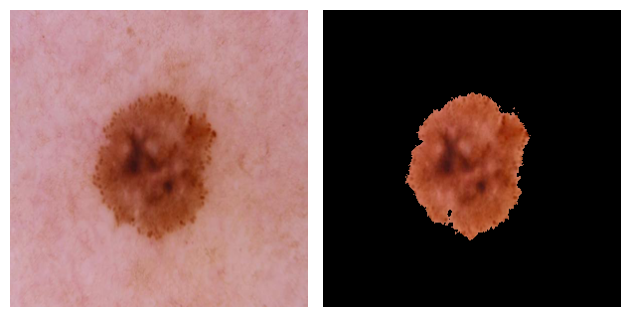

In [21]:
# Feeding model with a photo with a ground truth of having skin cancer

# Preprocessing image
img1 = prepro("img_data_o/test/1/ISIC_0028033.jpg")

In [22]:
# Model prediction
pred1 = cnn.predict(np.expand_dims(img1/255, 0))

if pred1 > 0.5:
    print("Skin cancer detected")
else:
    print("Skin cancer not detected")

pred1

1/1 [==============================] - 0s 93ms/step
Skin cancer not detected


array([[0.47027567]], dtype=float32)

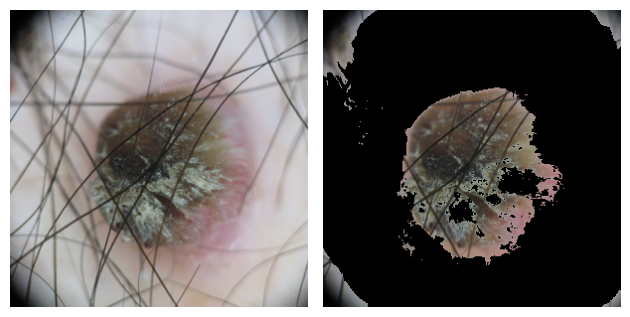

In [23]:
# Feeding model with a photo with a ground truth of NOT having skin cancer

# Preprocessing image
img2 = prepro("img_data_o/test/0/ISIC_0068219.jpg")

In [24]:
# Model prediction
pred2 = cnn.predict(np.expand_dims(img2/255, 0))

if pred2 > 0.5:
    print("Skin cancer detected")
else:
    print("Skin cancer not detected")

pred2

1/1 [==============================] - 0s 25ms/step
Skin cancer not detected


array([[0.4007371]], dtype=float32)

**Results**

Did not correctly identify skin cancer image, but correctly identified non-skin cancer image.

## Saving the model - Save did not occur

In [ ]:
# Export our model to HDF5 file
cnn.save("models/prod_4.h5")

In [ ]:
# Exporting model as Pickle file
import pickle

pickle.dump(cnn, open('models/prod_4.pkl', 'wb'))